# 制約付きLQR

参考：
* [Reinforcement Learning: Theory and Algorithms](https://rltheorybook.github.io/)
* [Safely Learning to Control the Constrained Linear Quadratic Regulator](https://arxiv.org/abs/1809.10121)

TODO: 元論文はPolytope制約だけど，これは実質二次制約と同じ？ちゃんと理解しよう．

[前回](RL_LQR_as_SDP.ipynb)，LQRが半正定値計画問題として解けることを見ました．
LQRの双対性をよく見ると，これはOccupancy measureを使ったMDPの線形計画問題とよく似ています（[RL_as_LP.ipynb](RL_as_LP.ipynb)参照）．

つまり，自然な形で他の制約を導入することができます．

## 制約付きLQR

もとのLQRでは次の問題を解くことを考えていました．
$$
\begin{array}{ll}
\operatorname{minimize} & \mathbb{E}_\pi\left[\sum_{t=0}^H c_t\left(x_t, u_t\right)\right] \\
\text { such that } & x_{t+1}=x_{t+1}=A_t x_t+B_t u_t+w_t\; t=0, \ldots, H
\end{array}
$$

ここにさらに次のような制約を考えます：

$$
\mathcal{X}:=\left\{x: x^\top F_x x \leq b_x\right\}
$$

合体して，次の問題を解きます：

$$
\begin{array}{ll}
\operatorname{minimize} & \lim_{H\to \infty}\frac{1}{H}\mathbb{E}_\pi\left[\sum_{t=0}^H c_t\left(x_t, u_t\right)\right] \\
\text { such that } & x_{t+1}=A_t x_t+B_t u_t+w_t\; t=0, \ldots, H\\
& x_t^\top F_x x_t \leq b_x
\end{array}
$$


これを双対形式で表しましょう．つまり，

$$
\begin{array}{ll}
\operatorname{minimize} & \operatorname{Trace}\left(\Sigma \cdot\left[\begin{array}{ll}
Q & 0 \\
0 & R
\end{array}\right]\right) \\
\text { subject to } & \Sigma_{x x}=\left(\begin{array}{ll}
A & B
\end{array}\right) \Sigma(A B)^{\top}+\sigma^2 I, \quad \Sigma \succeq 0,
\end{array}
$$

and

$$
\Sigma=\left[\begin{array}{ll}
\Sigma_{x x} & \Sigma_{x u} \\
\Sigma_{u x} & \Sigma_{u u}
\end{array}\right]
$$

に対して多面体の制約を追加します．
共分散行列を使えば$x_\infty^\top F_x x_\infty$は$\operatorname{Trace}(F_x \Sigma_{x x})$として評価できるので，制約として

$$
\operatorname{Trace}(F_x \Sigma_{x x}) \leq b_x
$$

を追加すれば良いことになります．

In [1]:
import numpy as np
from typing import NamedTuple


# 無限ホライゾン用です
class MDP(NamedTuple):
    d: int  # 状態の次元
    k: int  # 入力の次元
    A: np.ndarray  # 遷移行列
    B: np.ndarray  # 遷移行列
    Q: np.ndarray  # コスト行列
    R: np.ndarray  # コスト行列
    sigma: float  # ノイズの大きさ
    Fx: np.ndarray  # 制約のベクトル
    bx: float  # 制約の閾値


d = 4
k = 1
sigma = 0.1
A = np.array([
    [0, 1, 0, 0],
    [0, -0.1, 3, 0],
    [0, 0, 0, 1],
    [0, -0.5, 30, 0],
]) * 0.1
B = np.array([[0.,], [2.,], [0.,], [5.,]])
Q = np.array([
    [1., 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1., 0],
    [0, 0, 0, 0],
])
R = np.eye(1)
Fx = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1.],
])
bx = 0.5

mdp = MDP(d, k, A, B, Q, R, sigma, Fx, bx)

In [2]:
# 双対問題を解きます

import cvxpy as cp

Sxx = cp.Variable((d, d), symmetric=True)
Sxu = cp.Variable((d, k))
Suu = cp.Variable((k, k), symmetric=True)

S = cp.bmat([
    [Sxx, Sxu],
    [Sxu.T, Suu]
])

AB = np.block([mdp.A, mdp.B])
QR = np.block([
    [mdp.Q, np.zeros((d, k))],
    [np.zeros((k, d)), mdp.R],
])

constraints = [Sxx == AB @ S @ AB.T + mdp.sigma ** 2 * np.eye(d), S >> 0]

prob = cp.Problem(cp.Minimize(cp.trace(S @ QR)), constraints)
prob.solve()

S = S.value
Sux = Sxu.value.T
Sxx = Sxx.value

In [3]:
import matplotlib.pyplot as plt

# 制御器をダイナミクス上で走らせて得られる価値を観察します
gain = - Sux @ np.linalg.inv(Sxx)

x0 = np.random.randn(d).reshape(d, 1)

Vs = []
outputs = []
for seed in range(10):
    x = x0.copy()
    V = []
    xs = []
    for h in range(100):
        u = - gain @ x

        xs.append(x)

        # コストを計算します
        cost = x.T @ mdp.Q @ x + u.T @ mdp.R @ u
        V.append(cost)

        # ダイナミクスを進めます
        noise = np.random.randn(1)[None, :] * mdp.sigma
        x = mdp.A @ x + mdp.B @ u + noise

    cost = x.T @ mdp.Q @ x
    V.append(cost)

    V = np.array(V[::-1])
    V = np.cumsum(V)[::-1]
    Vs.append(V)
    outputs.append(xs)

In [4]:
# 制約付きの双対問題を解きます

import cvxpy as cp

Sxx = cp.Variable((d, d), symmetric=True)
Sxu = cp.Variable((d, k))
Suu = cp.Variable((k, k), symmetric=True)

S = cp.bmat([
    [Sxx, Sxu],
    [Sxu.T, Suu]
])

AB = np.block([mdp.A, mdp.B])
QR = np.block([
    [mdp.Q, np.zeros((d, k))],
    [np.zeros((k, d)), mdp.R],
])
constraints = [Sxx == AB @ S @ AB.T + mdp.sigma ** 2 * np.eye(d), S >> 0]

# 追加の制約です （角速度が一定以上になるようにします）
constraints += [cp.trace(mdp.Fx @ Sxx) >= mdp.bx,]

prob = cp.Problem(cp.Minimize(cp.trace(S @ QR)), constraints)
prob.solve()

S = S.value
Sux = Sxu.value.T
Sxx = Sxx.value

In [5]:
import matplotlib.pyplot as plt

# 制御器をダイナミクス上で走らせて得られる価値を観察します
gain = - Sux @ np.linalg.inv(Sxx)

cVs = []
coutputs = []
for seed in range(10):
    x = x0.copy()
    V = []
    xs = []
    for h in range(100):
        u = - gain @ x

        xs.append(x)

        # コストを計算します
        cost = x.T @ mdp.Q @ x + u.T @ mdp.R @ u
        V.append(cost)

        # ダイナミクスを進めます
        noise = np.random.randn(1)[None, :] * mdp.sigma
        x = mdp.A @ x + mdp.B @ u + noise

    cost = x.T @ mdp.Q @ x
    V.append(cost)

    V = np.array(V[::-1])
    V = np.cumsum(V)[::-1]
    cVs.append(V)
    coutputs.append(xs)

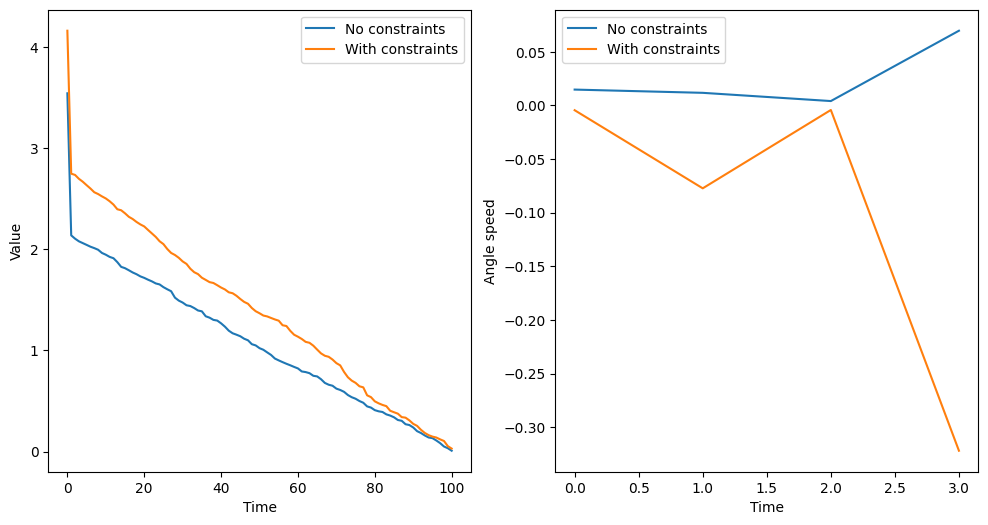

In [6]:
mean_V = np.array(Vs).mean(axis=0)
mean_cV = np.array(cVs).mean(axis=0)
mean_output = np.array(outputs).mean(axis=0)[-1]
mean_coutput = np.array(coutputs).mean(axis=0)[-1]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mean_V, label=f"No constraints")
plt.plot(mean_cV, label=f"With constraints")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_output, label=f"No constraints")
plt.plot(mean_coutput, label=f"With constraints")
plt.xlabel("Time")
plt.ylabel("Angle speed")
plt.legend()